In [1]:
import calendar
import cmocean as cmo
import gc
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# Define timestamp version of data to plot
TIMESTAMP_OUT = '02092026_1424'

# Define remaning parameters
HEM = 'sh'
MODEL_DIR = 'cnn-wtd-pt'
MODEL_STR = MODEL_DIR.replace('-', '_')

In [3]:
data_root = '/data/globus/jbassham/thesis-rough'

In [4]:
# Load uncertainty (from lr input)
fnam = f'lr-input/{HEM}/{TIMESTAMP_OUT}/test_{HEM}19922020_{TIMESTAMP_OUT}.npz'

data = np.load(os.path.join(data_root, fnam))
r_test = data['r_test']

In [5]:
# Load test split indices (from lr input) 
fnam = f'lr-input/{HEM}/01232026_1338/split_indices_lr_{HEM}19922020_01232026_1338.npz'

data = np.load(os.path.join(data_root, fnam))
test_idx = data['test_idx']

In [6]:
# Load coordinates
fnam = f'coordinates/{HEM}/01072026_1643/coord_{HEM}19922020_01072026_1643.npz'

data = np.load(os.path.join(data_root, fnam))
lat = data['lat']
lon = data['lon']

# Load time in while slicing to test indices
time = data['time'][test_idx]

In [7]:
# Get filename for nan mask
fnam = f'mask-norm/{HEM}/{TIMESTAMP_OUT}/nan_mask_{HEM}19922020_{TIMESTAMP_OUT}.npz'

# Load time variable nan mask file
data = np.load(os.path.join(data_root, fnam))

# Load in nan mask and slice to test indices
nan_mask = data['nan_mask'][test_idx]

print(np.shape(nan_mask))

(731, 81, 522)


In [8]:
# If the model is persistance
if MODEL_STR == 'ps':

    # Shift nan mask one day forward
    nan_mask = nan_mask[1:,:,:]

    # Shift uncertainty one day forward
    r_test = r_test[1:,:,:]

    # Shift time array one day forward
    time = time[1:]

print(np.shape(nan_mask))

(731, 81, 522)


In [9]:
# # Load test outputs
fnam = f"model-output/{MODEL_DIR}/{HEM}/{TIMESTAMP_OUT}/preds_{MODEL_STR}_{HEM}19922020_{TIMESTAMP_OUT}.npz"

data = np.load(os.path.join(data_root, fnam))

y_pred = data['y_pred']
y_true = data['y_true']

# print(np.shape(y_pred))
# print(np.shape(y_true))
# print(np.shape(r_test))

In [10]:
# Extract variables from output channels
u_pred = y_pred[:,0,:,:]
v_pred = y_pred[:,1,:,:]

u_true = y_true[:,0,:,:]
v_true = y_true[:,1,:,:]

In [11]:
# Mask invalid points in model output before evaluation
# NOTE CNN input of 0 at invalid points and LR output of 0 for vi (imag) component
u_pred = np.where(nan_mask, np.nan, u_pred)
v_pred = np.where(nan_mask, np.nan, v_pred)

u_true = np.where(nan_mask, np.nan, u_true)
v_true = np.where(nan_mask, np.nan, v_true)

r_test = np.where(nan_mask, np.nan, r_test)

In [12]:
def correlation(pred, true):

    """
    Pearson Correlation
    """

    predbar = np.nanmean(pred, axis = 0) # mean predicted
    truebar = np.nanmean(true, axis = 0) # mean true

    covariance = np.nansum((pred - predbar) * (true - truebar), axis = 0) # covariance between predicted and true
    
    stdpred = np.sqrt(np.nansum((pred - predbar)**2, axis = 0)) # standard deviation predited
    stdtrue = np.sqrt(np.nansum((true - truebar)**2, axis = 0)) # standard deviation true

    correlation = covariance / (stdpred * stdtrue)

    return correlation

In [13]:
def weighted_correlation(pred, true, r, epsilon = 1e-4):

    """
    Weighted Pearson Correlation referenced from:
    https://www.air.org/sites/default/files/2021-06/Weighted-and-Unweighted-Correlation-Methods-Large-Scale-Educational-Assessment-April-2018.pdf
    
    """

    w = 1 / (r + epsilon)

    def weighted_mean(x, w):
        return np.nansum(w * x, axis = 0) / np.nansum(w, axis = 0)

    predbar = weighted_mean(pred, w) # weighted mean predicted
    truebar = weighted_mean(true, w) # weighted mean true

    weighted_cov = np.nansum(w * (pred - predbar) * (true - truebar), axis = 0) # weighted covariance between predicted and true
    
    weighted_stdpred = np.sqrt(np.nansum(w * (pred - predbar)**2, axis = 0)) # weighted standard deviation predited
    weighted_stdtrue = np.sqrt(np.nansum(w * (true - truebar)**2, axis = 0)) # weighted standard deviation true

    correlation = weighted_cov / (weighted_stdpred * weighted_stdtrue)

    return correlation

In [14]:
def skill(pred, true, epsilon = 1e-4):
    """
    'Nash-Sutfliffe Efficiency (NSE)'

    - Instable in areas with low variance, error outliers
    """
    # NOTE excluding epsilon = 1e-4 from denominator for now

    mse = np.nanmean((true - pred)**2, axis = 0) # mean square error
    # NOTE above is not equivalent to np.nanvar(true-pred), which excludes bias term
    # MSE = E[(y-x)^2]
    # = (E[y-x])^2 + Var(y-x)
    # = bias^2 + Var(y-x)
    # Can prove the above

    truebar = np.nanmean(true, axis = 0) # mean true

    vartrue = np.nanmean((true - truebar)**2, axis = 0) # variance in true
    # NOTE above is equivalent to np.nanvar()

    skill = 1 - mse / (vartrue + epsilon)

    return skill

In [15]:
def weighted_skill(pred, true, r, epsilon = 1e-4):
    # NOTE including epsilon = 1e-4 in the weights in case of uncertainty r ~ 0

    w = 1 / (r + epsilon)

    mse = np.nanmean(( w * (true - pred))**2, axis = 0) # mean square error
    # NOTE above is not equivalent to np.nanvar(true-pred), which excludes bias term

    truebar = np.nanmean(true, axis = 0) # mean true

    vartrue = np.nanmean(( w * (true - truebar))**2, axis = 0) # variance in true
    # NOTE above is equivalent to np.nanvar()

    weighted_skill = 1 - mse / (vartrue + epsilon)

    return weighted_skill

In [16]:
def rmse_skill(pred, true, epsilon = 1e-4):
    """
    'Normalized RMSE skill score', 'RMSE skill score relative to climatology'

    - RMSE of the forecast relative to the RMSE of the referance (std of the observation here)
    - Stable with low-variance outliers

    Used in:
    Hoffman, et. al. (2023)

    Zai, Bitz (2021)

    Mayer, Yang (2023). 'Calibration of derterministic NWP forecsts and its impact on verification'
    https://www.sciencedirect.com/science/article/pii/S0169207022000486?utm_source=chatgpt.com

    """
    # NOTE excluding epsilon = 1e-4 from denominator for now

    mse = np.nanmean((true - pred)**2, axis = 0) # mean square error
    # NOTE above is not equivalent to np.nanvar(true-pred), which excludes bias term
    # MSE = E[(y-x)^2]
    # = (E[y-x])^2 + Var(y-x)
    # = bias^2 + Var(y-x)
    # Can prove the above

    truebar = np.nanmean(true, axis = 0) # mean true

    vartrue = np.nanmean((true - truebar)**2, axis = 0) # variance in true
    # NOTE above is equivalent to np.nanvar()

    skill = 1 - np.sqrt(mse) / np.sqrt((vartrue + epsilon))

    return skill

In [17]:
def plot_metric_month(data, lon, lat, metric_str, cmap = cmo.cm.balance_r, vmin = -1, vmax = 1, cbar_label = None):

    # Set longitude bounds for plot (full zonal coverage)
    lon_min = -180
    lon_max = 180

    # Set latitude bounds based on hemisphere
    if HEM == 'sh':
        lat_min = -90
        lat_max = -65
    elif HEM =='nh':
        lat_min = 65
        lat_max = 90

    # Define plot proection based on hempisphere
    if HEM == 'sh':
        projection = ccrs.SouthPolarStereo()
    elif HEM == 'nh':
        projection = ccrs.NorthPolarStereo()

    # Define data-to-plot's coordinate reference system
    # NOTE, used for 'crs' and 'transform' cartopy parameters
    crs = ccrs.PlateCarree()
    
    # Initialize subplots
    fig, axs = plt.subplots(
        nrows = 2,
        ncols = 6,
        figsize = (18,6),
        subplot_kw = {'projection': projection},
        constrained_layout = True
    )

    # Flatten array to single Cartopy GeoAxes for iteration
    axs = axs.flatten()

    # Get month numbers from time variable
    months = (time.astype('datetime64[M]').astype(int) % 12) + 1

    for m in range(12):

        ax = axs[m]

        month_data = data[m]

        # Plot left plot; zonal evaluation
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs = crs)
        ax.coastlines()
        # Plot pcolormesh plot
        pcm = ax.pcolormesh(
            lon, lat, month_data,
            transform = crs,
            cmap = cmap, vmin = vmin, vmax = vmax
        )

        # Get month string for plot title
        month_string = calendar.month_name[m + 1]

        ax.set_title(f"{month_string}")

    # Add colorbar
    cbar = fig.colorbar(pcm, ax = axs, orientation='vertical', shrink=0.85)

    # Label colorbar
    if cbar_label is not None:
        cbar.set_label(cbar_label, fontsize = '14', fontweight = 'bold')

    # Add title to plot
    fig.suptitle(f"Metric: {metric_str}; ML Model: {MODEL_STR}", fontweight = 'bold')

    # Format with tight layout
    fig.tight_layout

    # # Define filemane for figure
    # fnam = f"{metric_str}_{MODEL_STR}_{TIMESTAMP_OUT}.png"

    # # Save figure
    # plt.savefig(os.path.join(PATH_DEST, fnam), bbox_inches = 'tight')

    return

In [18]:
def plot_fcn_month(pred, true, time, lon, lat, metric_fcn, metric_str, weighted = False, r = None, cmap = cmo.cm.balance_r, vmin = -1, vmax = 1, cbar_label = None):

    """

    Computes and plots the given metric function for each month of the year
    Given inputs:
        lon: longitude
        lat: latitude
        metric_fcn: skill, weighted_skill, correlation, or weighted_correlation functions
        *metric_args and **metric_kwargs: attitional arguments for metric functions (ie: r for weighted)

    """

    # Get shape for spatial dimensions
    nt, nlat, nlon = np.shape(pred)

    # Define number of month bins
    nm = 12 # number months

    # Initialize empty arrays containing metrics for each month of the year
    metric_allyear = np.full((nm, nlat, nlon), np.nan)

    # Get month numbers from time variable
    months = (time.astype('datetime64[M]').astype(int) % 12) + 1

    # # Create array of month strings for plot titles
    # month_strings = [calendar.month_name[m] for m in range(1,13)]

    for i in range(12):

        # Initialize keyword arguments (r for weighted metrics)
        metric_kwargs = {}

        # Get current month
        month = months == (i + 1)

        if weighted:

            metric_kwargs["r"] = r[month,:,:]

            metric_month = metric_fcn(
                pred[month,:,:],
                true[month,:,:],
                **metric_kwargs,
            )
            
        else:
            metric_month = metric_fcn(
                pred[month,:,:],
                true[month,:,:],
            )

        # Fill current month in year long array
        metric_allyear[i, :, :] = metric_month

    # Plot the metrics for each month
    plot_metric_month(metric_allyear, lon, lat, f"{metric_str}", cbar_label = cbar_label)

    # Return arrays with metric for each month
    return metric_allyear

/tmp/ipykernel_2819911/404753664.py:9: RuntimeWarning: Mean of empty slice
  mse = np.nanmean((true - pred)**2, axis = 0) # mean square error
/tmp/ipykernel_2819911/404753664.py:16: RuntimeWarning: Mean of empty slice
  truebar = np.nanmean(true, axis = 0) # mean true
/tmp/ipykernel_2819911/404753664.py:18: RuntimeWarning: Mean of empty slice
  vartrue = np.nanmean((true - truebar)**2, axis = 0) # variance in true
/tmp/ipykernel_2819911/404753664.py:9: RuntimeWarning: Mean of empty slice
  mse = np.nanmean((true - pred)**2, axis = 0) # mean square error
/tmp/ipykernel_2819911/404753664.py:16: RuntimeWarning: Mean of empty slice
  truebar = np.nanmean(true, axis = 0) # mean true
/tmp/ipykernel_2819911/404753664.py:18: RuntimeWarning: Mean of empty slice
  vartrue = np.nanmean((true - truebar)**2, axis = 0) # variance in true
/tmp/ipykernel_2819911/2624561170.py:6: RuntimeWarning: Mean of empty slice
  mse = np.nanmean(( w * (true - pred))**2, axis = 0) # mean square error
/tmp/ipykernel

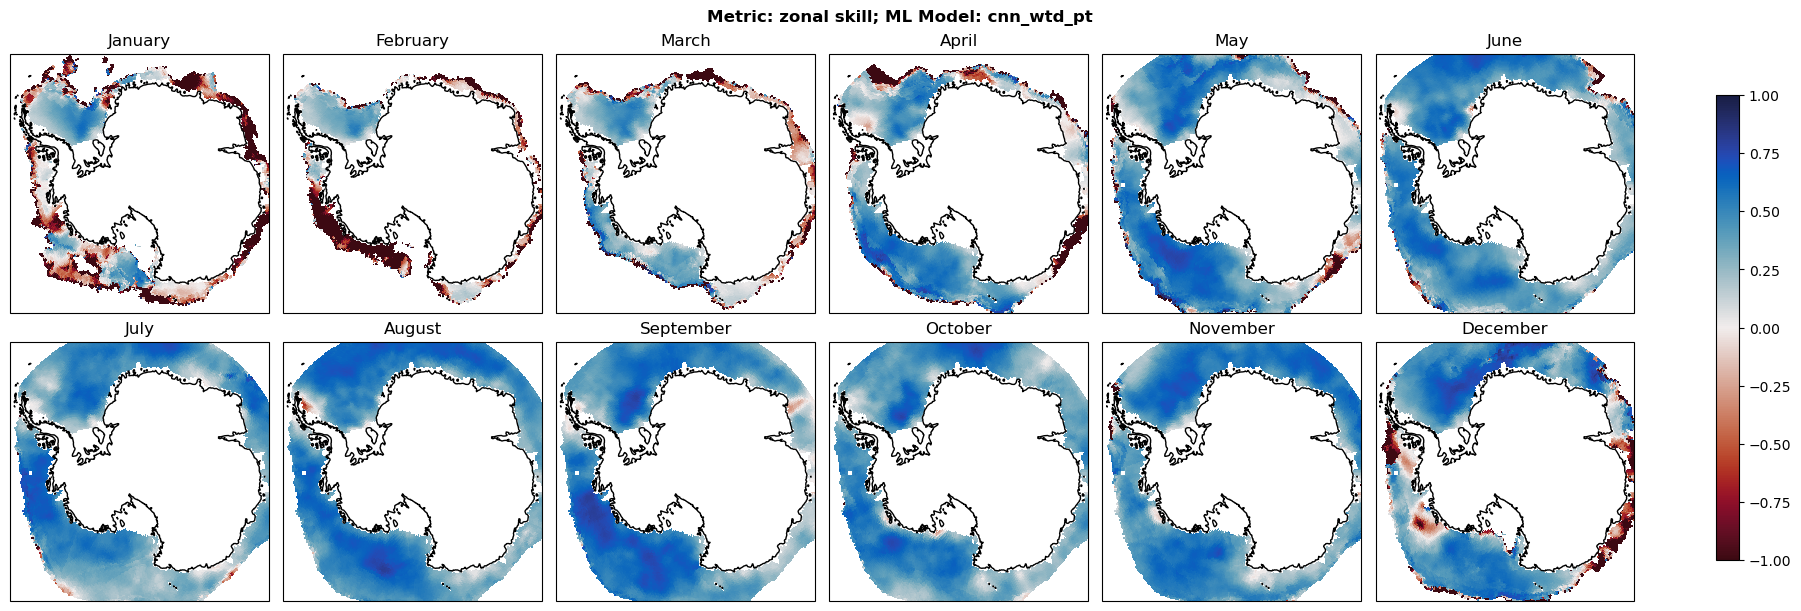

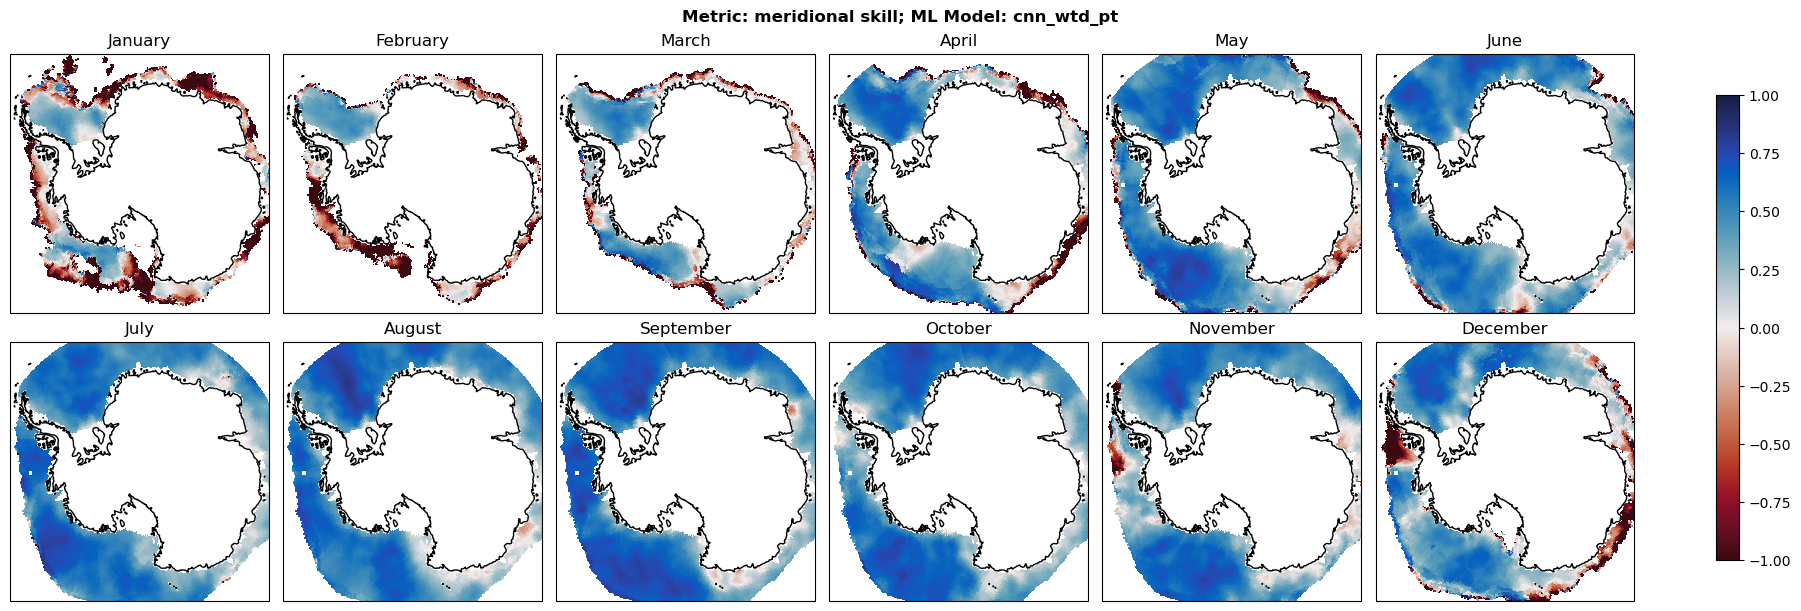

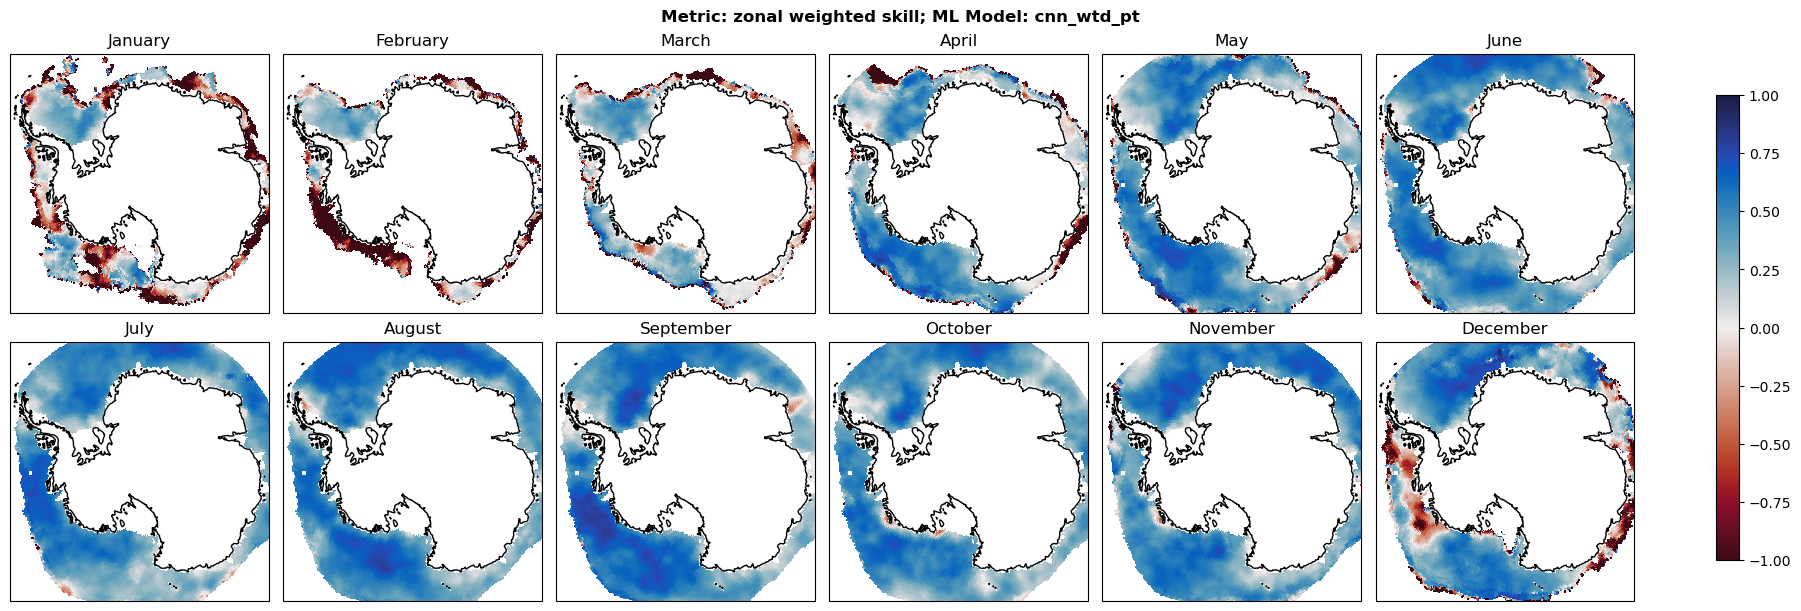

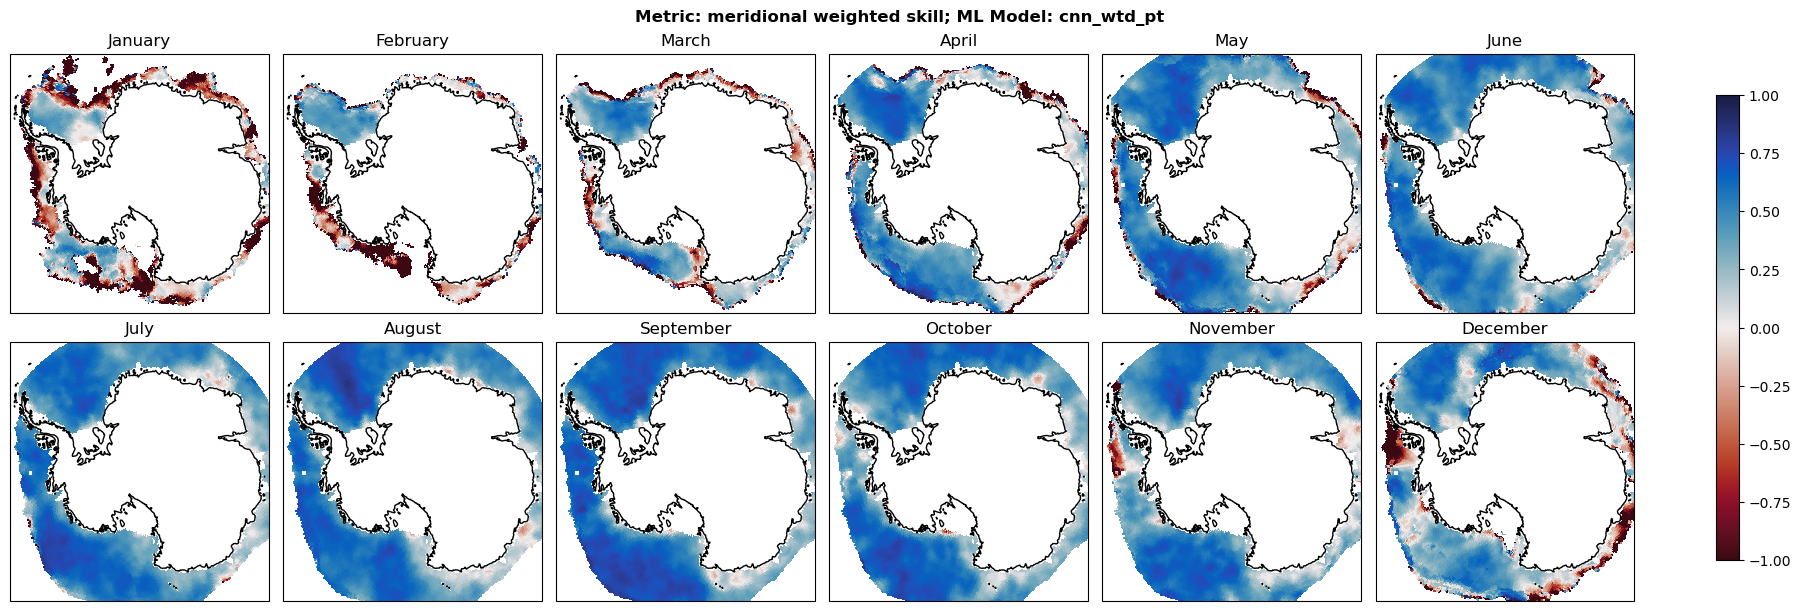

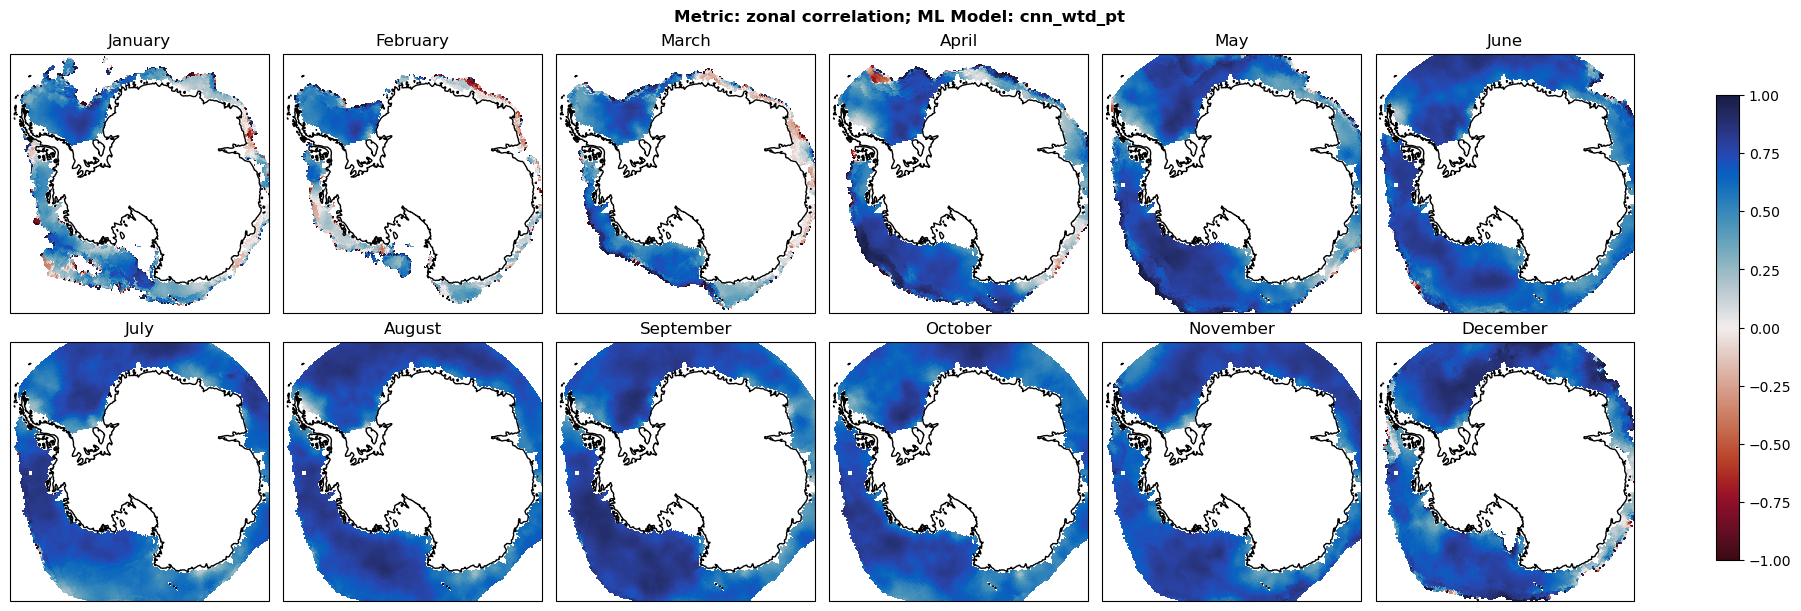

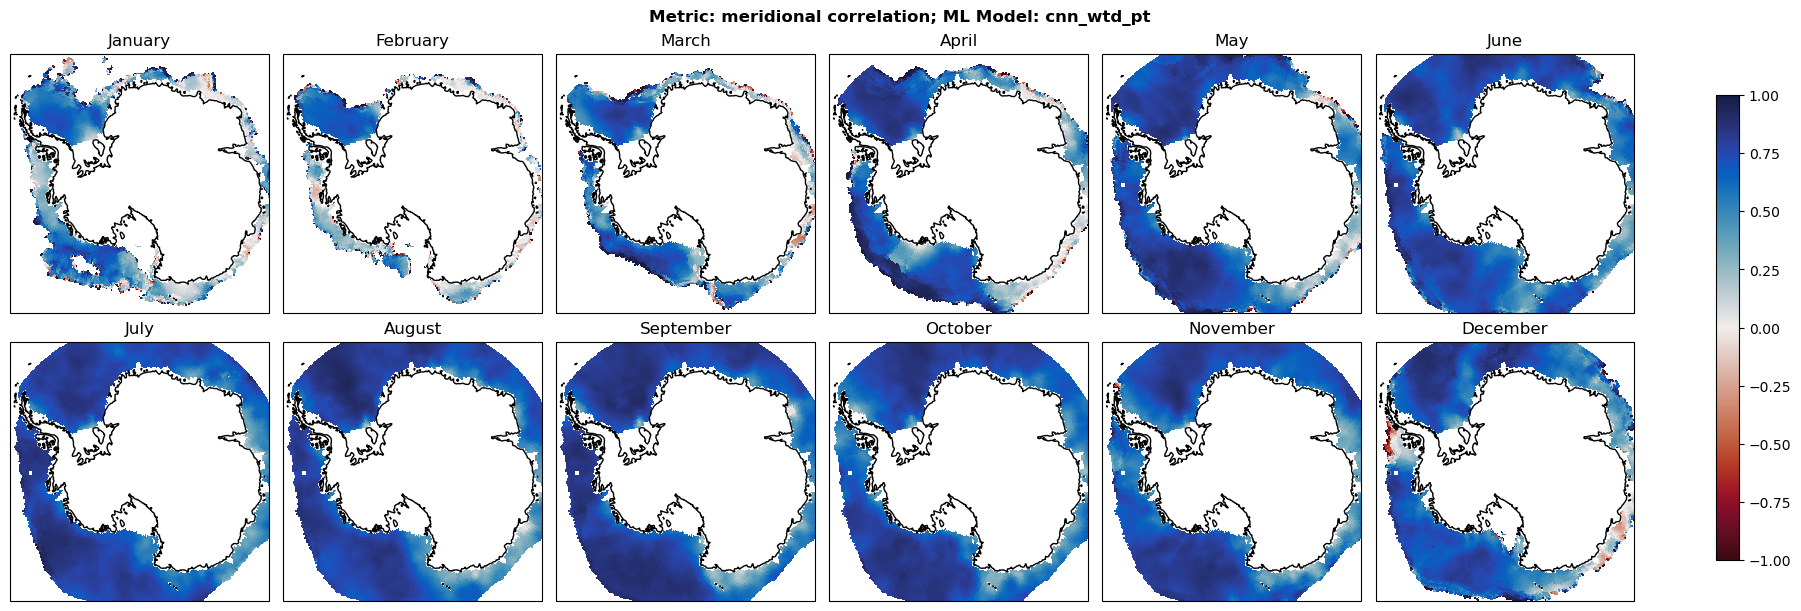

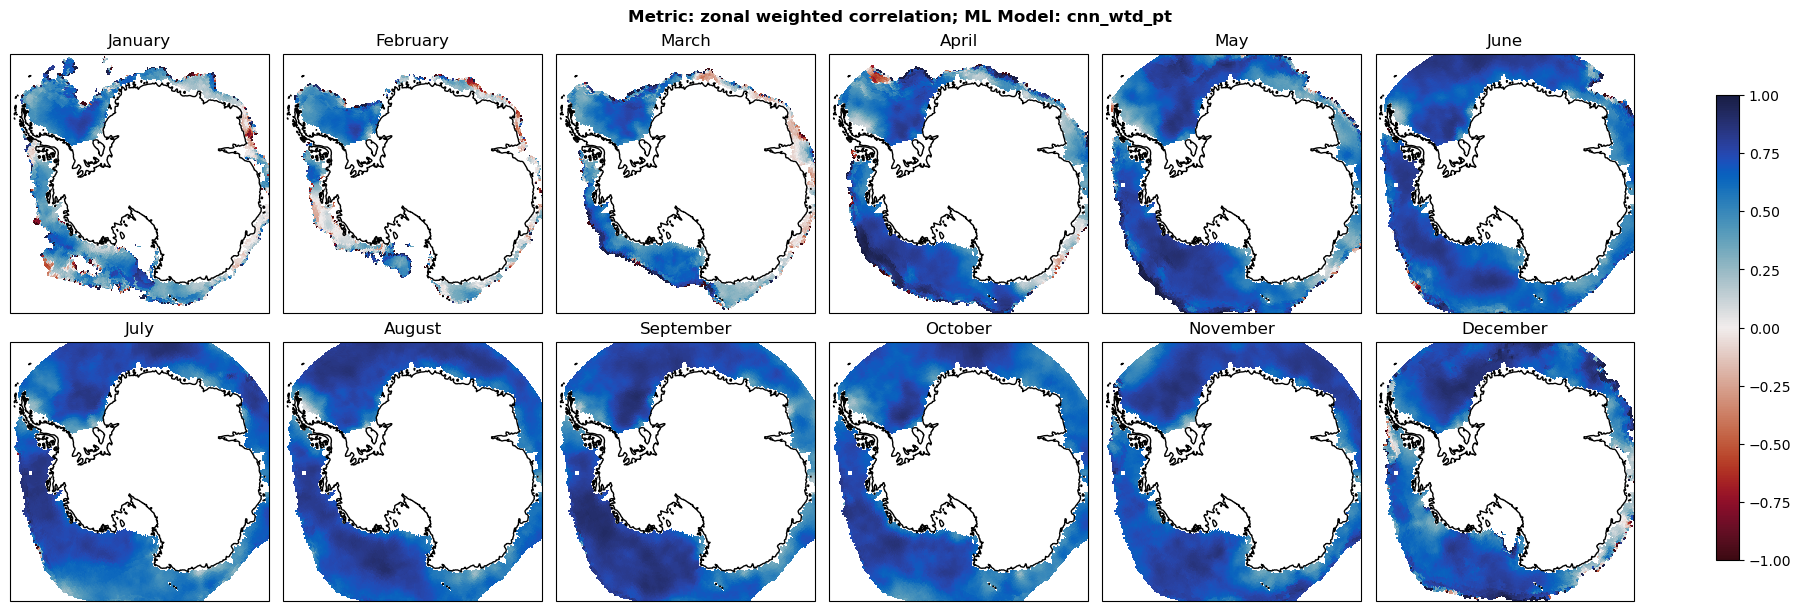

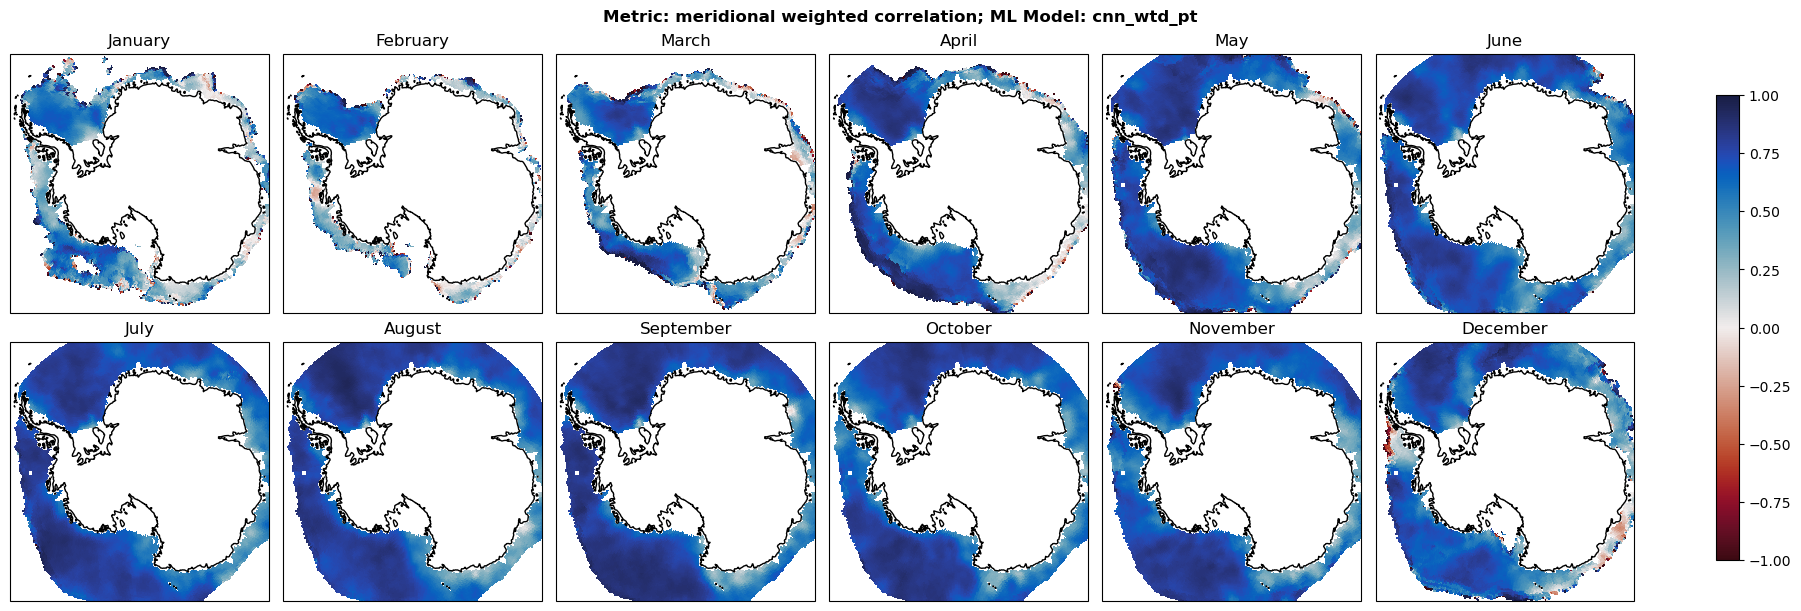

In [19]:
# Compute skill as a function of month
u_skill_month = plot_fcn_month(u_pred, u_true, time, lon, lat, skill, 'zonal skill')
v_skill_month = plot_fcn_month(v_pred, v_true, time, lon, lat, skill, 'meridional skill')

# Compute weighted skill as a function of month
u_wtd_skill_month = plot_fcn_month(u_pred, u_true, time, lon, lat, weighted_skill, 'zonal weighted skill', weighted = True, r = r_test)
v_wtd_skill_month = plot_fcn_month(v_pred, v_true, time, lon, lat, weighted_skill, 'meridional weighted skill', weighted = True, r = r_test)

# Compute weighted correlation as a function of month
u_corr_month = plot_fcn_month(u_pred, u_true, time, lon, lat, correlation, 'zonal correlation')
v_corr_month = plot_fcn_month(v_pred, v_true, time, lon, lat, correlation, 'meridional correlation')

# Compute weighted correlation as a function of month
u_wtd_corr_month = plot_fcn_month(u_pred, u_true, time, lon, lat, weighted_correlation, 'zonal weighted correlation', weighted = True, r = r_test)
v_wtd_corr_month = plot_fcn_month(v_pred, v_true, time, lon, lat, weighted_correlation, 'meridional weighted correlation', weighted = True, r = r_test)


In [20]:
def plot_avg_metric(u_metric, v_metric, metric_str):
    """
    Plots the spatial average of metric for each month in time series
    """

    # Create array of month strings for plot titles
    month_strings = [calendar.month_name[m] for m in range(1,13)]

    # Average into monthly bins
    u_metric_bar = np.nanmean(u_metric, axis = (1,2))
    v_metric_bar = np.nanmean(v_metric, axis = (1,2))

    plt.plot(u_metric_bar, marker='o', label='zonal')
    plt.plot(v_metric_bar, marker='o', label='meridional')
    plt.xticks(np.arange(12), month_strings, rotation=45)
    plt.ylabel('metric')
    plt.title(f"{metric_str} Spatial Mean; ML Model: {MODEL_STR.upper()}; {HEM}", fontsize = 14, fontweight = 'bold')
    plt.legend()

    plt.show()

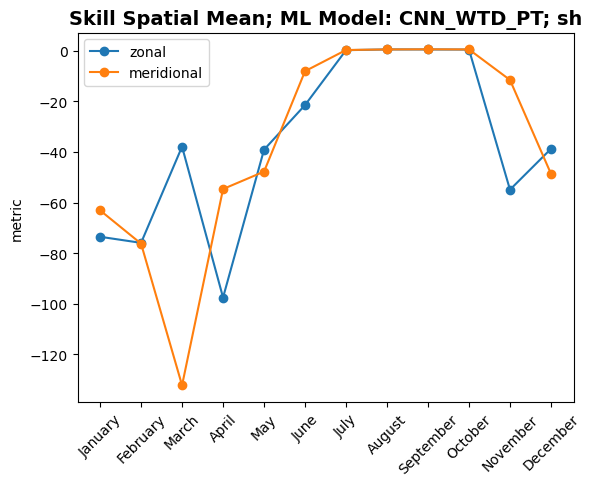

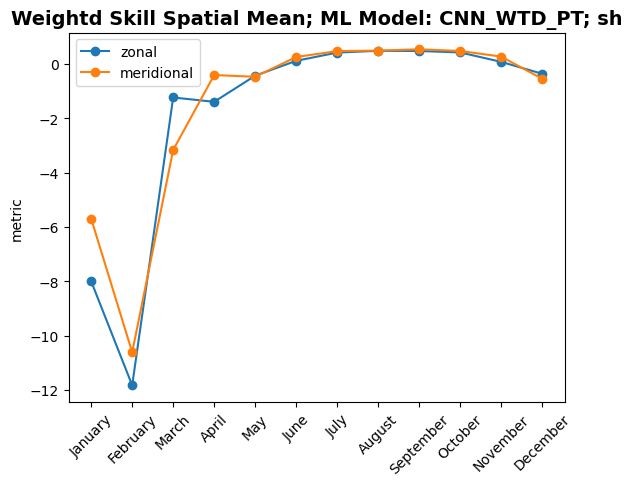

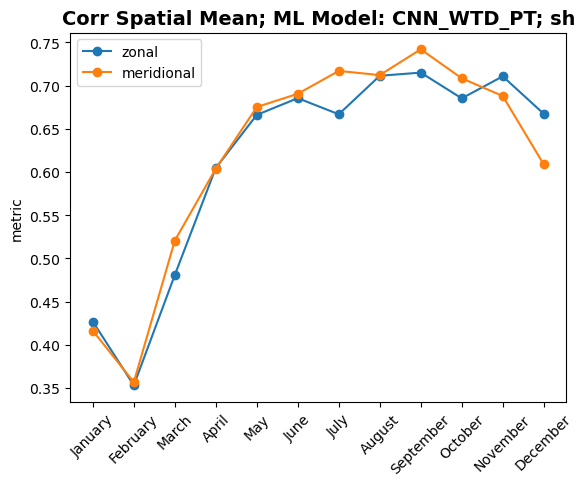

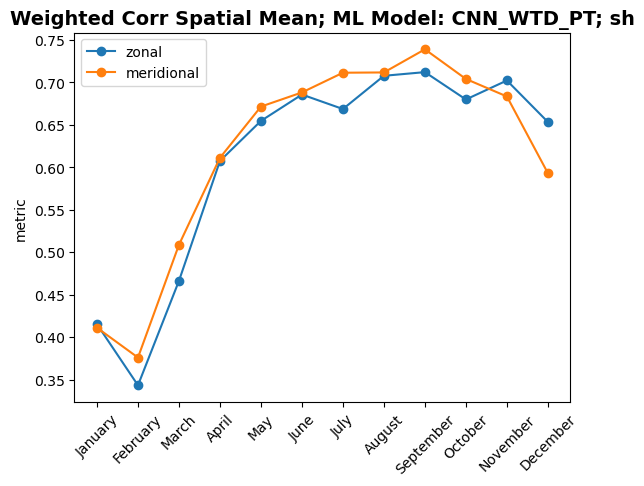

In [21]:
# Compute mean skill each month
plot_avg_metric(u_skill_month , v_skill_month, 'Skill')

# Compute mean weighted skill each month
plot_avg_metric(u_wtd_skill_month , v_wtd_skill_month, 'Weightd Skill')

# Compute mean weighted skill each month
plot_avg_metric(u_corr_month , v_corr_month, 'Corr')

# Compute mean weighted skill each month
plot_avg_metric(u_wtd_corr_month , v_wtd_corr_month, 'Weighted Corr')

In [22]:
def plot_median_metric(u_metric, v_metric, metric_str):
    """
    Plots the spatial average of metric for each month in time series
    """

    # Create array of month strings for plot titles
    month_strings = [calendar.month_name[m] for m in range(1,13)]

    # Average into monthly bins
    u_metric_med = np.nanmedian(u_metric, axis = (1,2))
    v_metric_med = np.nanmedian(v_metric, axis = (1,2))

    plt.plot(u_metric_med, marker='o', label='zonal')
    plt.plot(v_metric_med, marker='o', label='meridional')
    plt.xticks(np.arange(12), month_strings, rotation=45)
    plt.ylabel('metric')
    plt.title(f"{metric_str} Spatial Median; ML Model: {MODEL_STR.upper()}; {HEM}", fontsize = 14, fontweight = 'bold')
    plt.legend()


    plt.show()

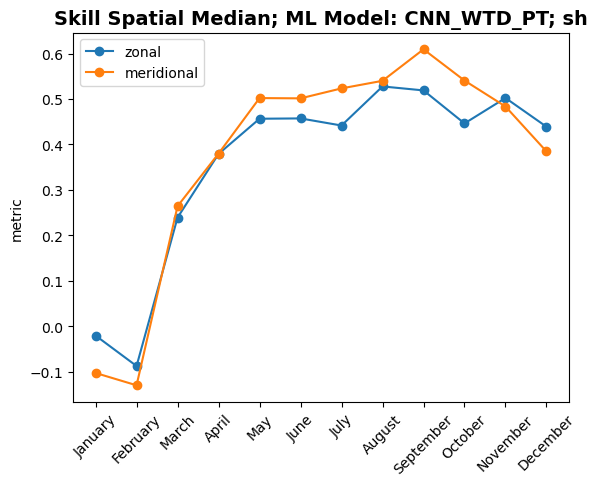

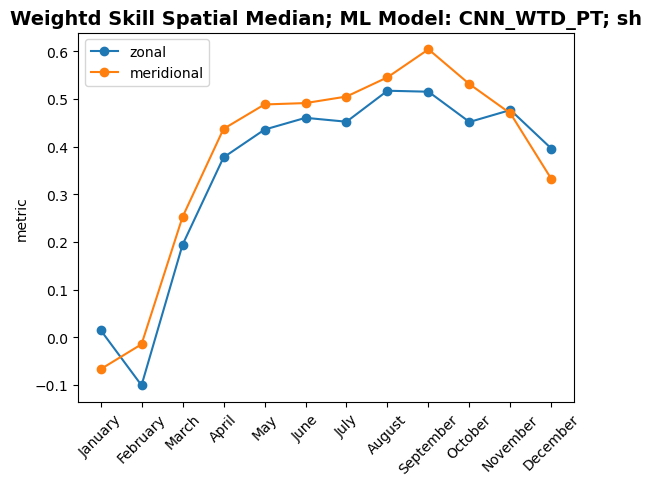

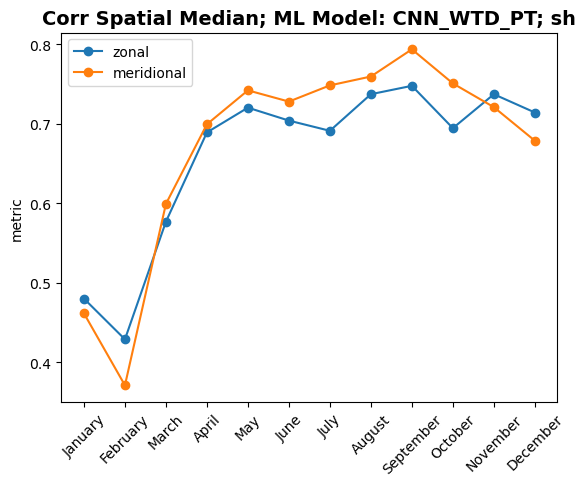

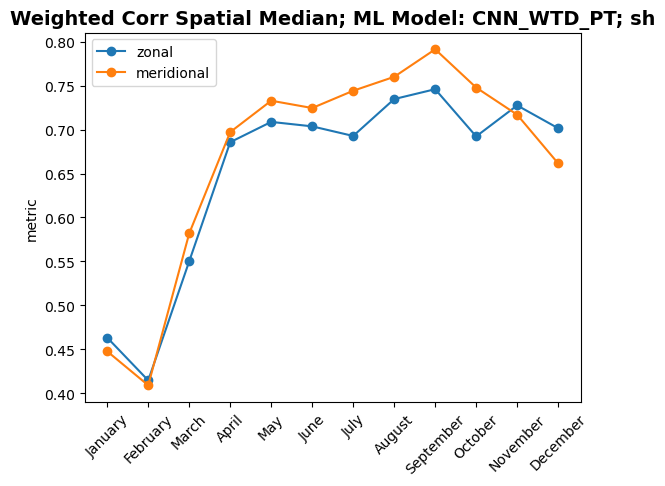

In [23]:
# Compute mean skill each month
plot_median_metric(u_skill_month , v_skill_month, 'Skill')

# Compute mean weighted skill each month
plot_median_metric(u_wtd_skill_month , v_wtd_skill_month, 'Weightd Skill')

# Compute mean weighted skill each month
plot_median_metric(u_corr_month , v_corr_month, 'Corr')

# Compute mean weighted skill each month
plot_median_metric(u_wtd_corr_month , v_wtd_corr_month, 'Weighted Corr')

In [24]:
def pdf_monthly(u_data, v_data, metric_str = None, xlim = None, ylim = None):

    # Initialize subplots for 12 months
    fig, axs = plt.subplots(
        nrows = 2,
        ncols = 6,
        figsize = (18,6),
        constrained_layout = True
    )

    # Flatten axs array for iteration
    axs = axs.flatten()

    # Define number of bins
    n_bins = 30

    # Iterate through months
    for m in range(12):
        
        # Get axis for current month
        ax = axs[m]

        # Plot u histogram with transparency
        ax.hist(u_data[m,:,:].flatten(), alpha = 0.85, bins = n_bins, density = 'True', label = 'zonal')

        # Plot v histogram with transparency
        ax.hist(v_data[m,:,:].flatten(), alpha = 0.85, bins = n_bins, density = 'True', label = 'meridional')

        if xlim:
            ax.set_xlim(xlim)

        if ylim:
            ax.set_ylim(ylim)

        # Get month string for plot title
        month_string = calendar.month_name[m + 1]

        ax.set_title(f"{month_string}")

    # Get axis handles and lables from one axs
    h, l = axs[0].get_legend_handles_labels()

    fig.legend(h, l)

    plt.suptitle(f"{metric_str}; ML Model: {MODEL_STR.upper()}; {HEM}", fontsize = 14, fontweight = 'bold')

    plt.show()

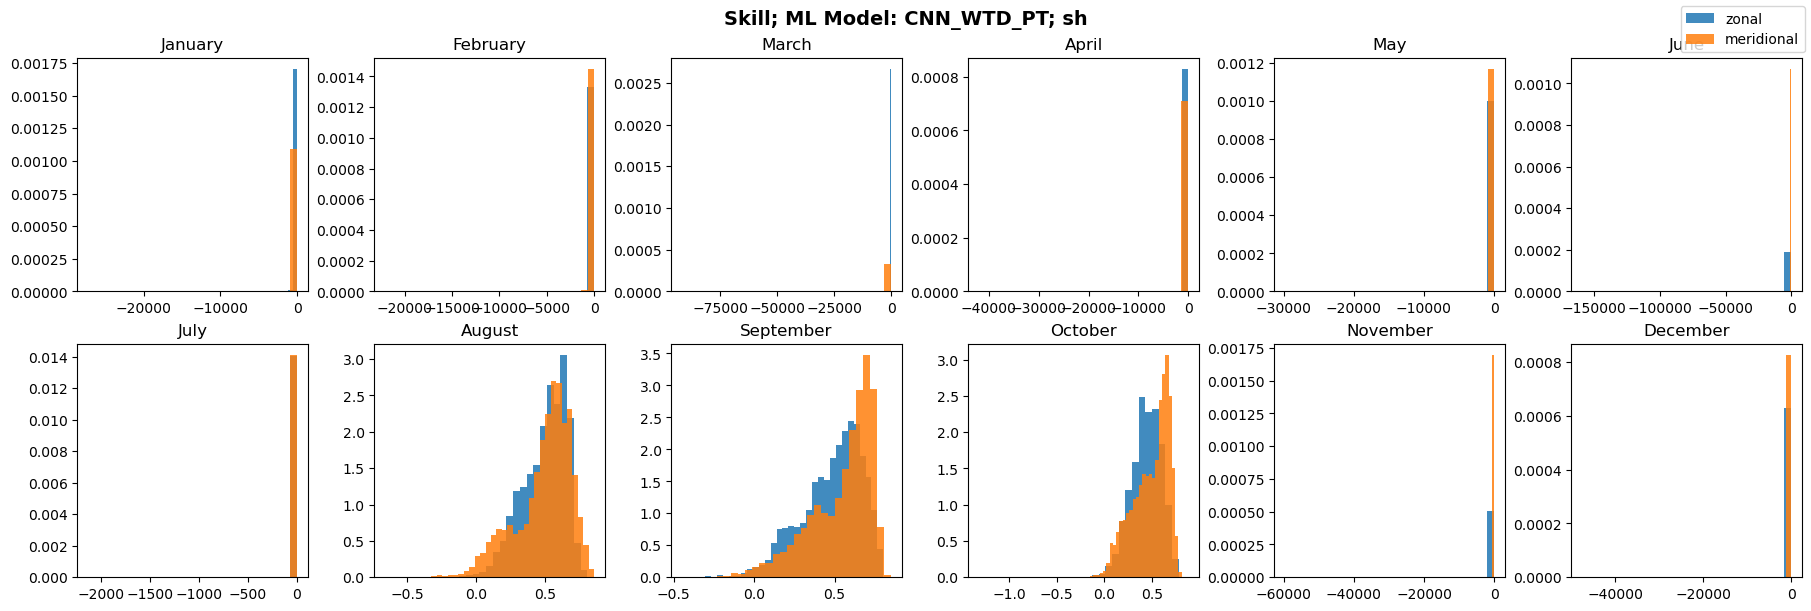

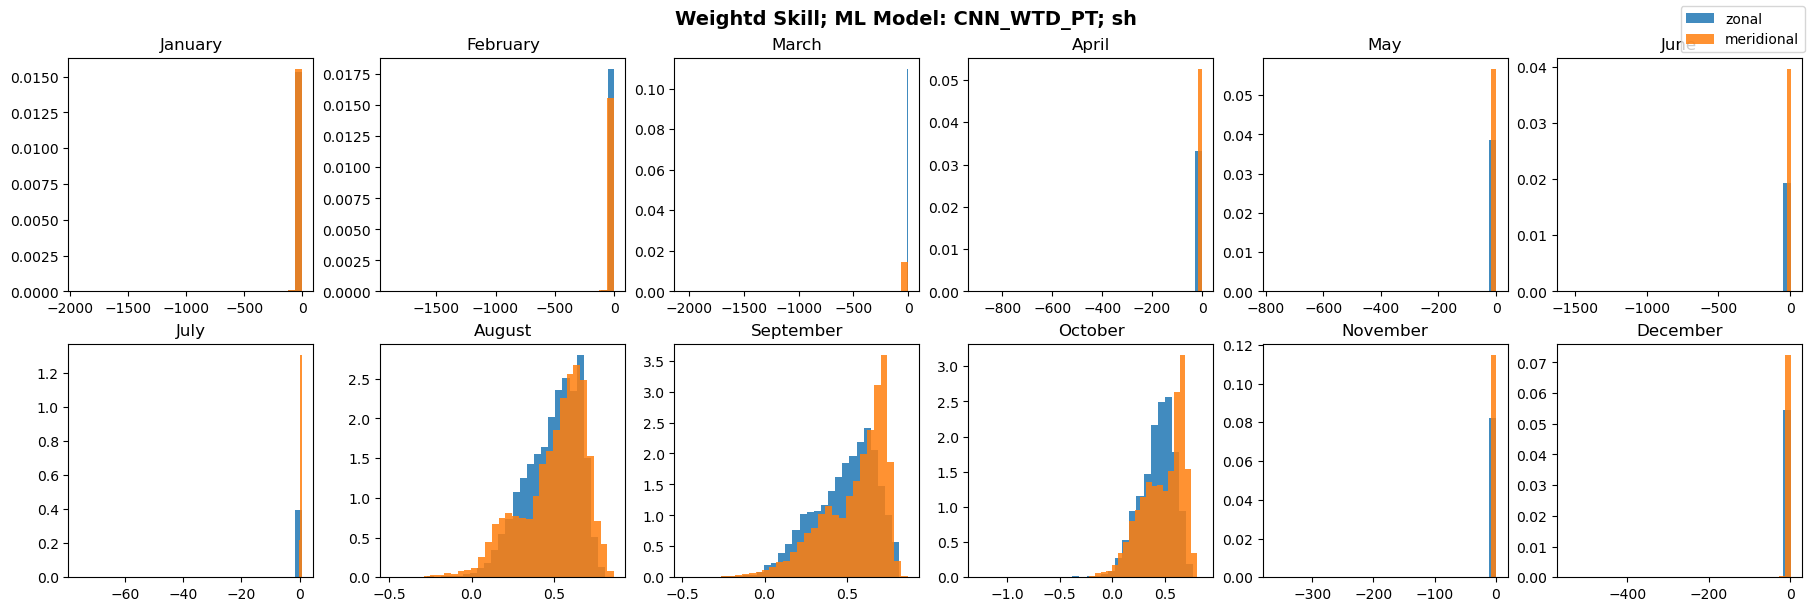

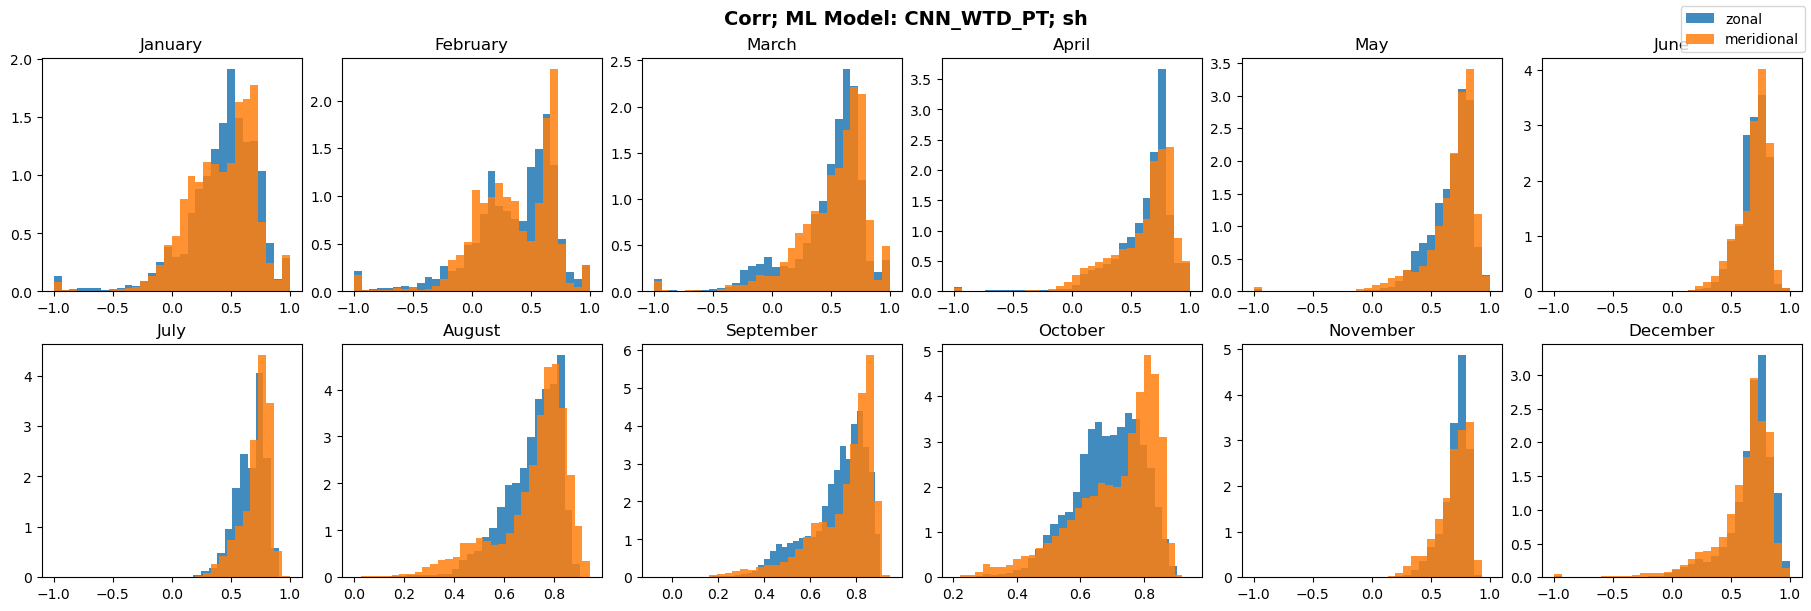

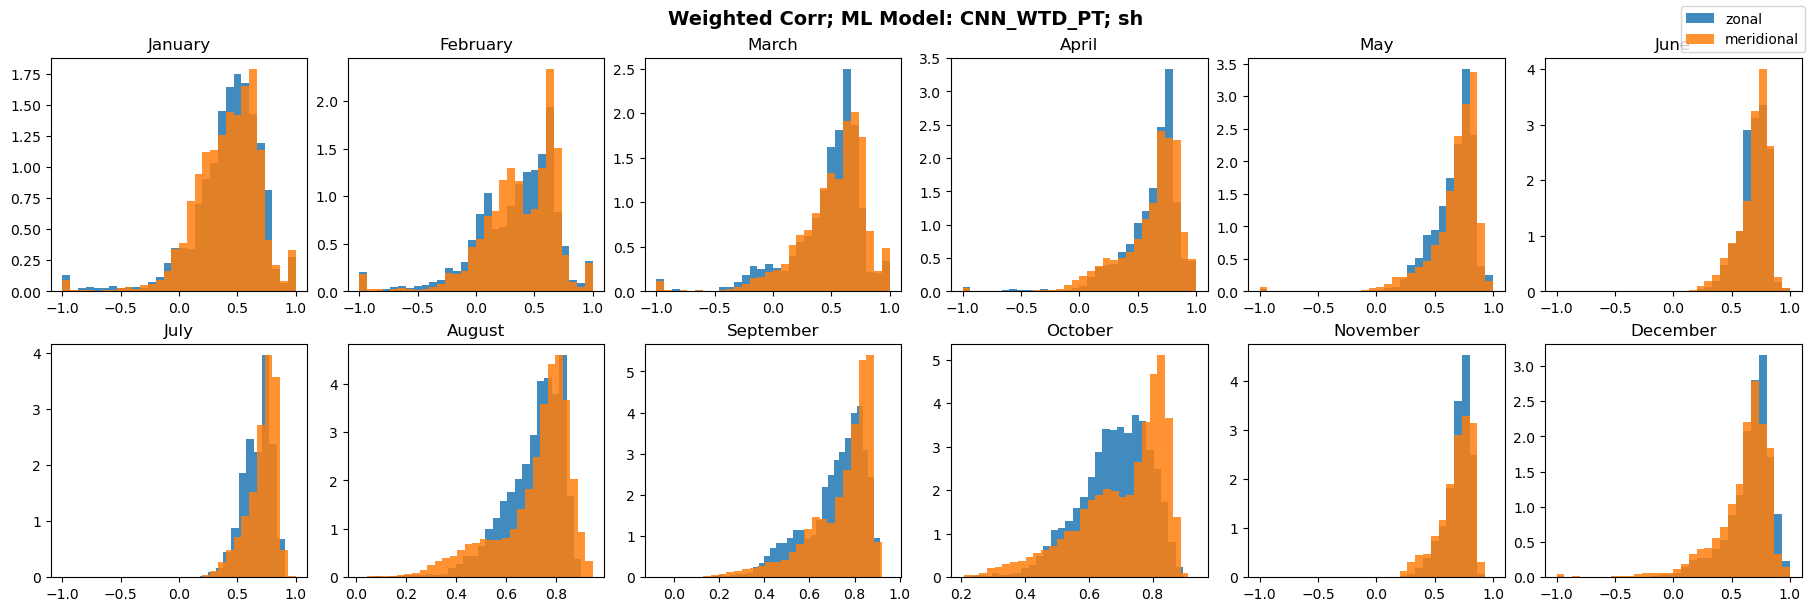

In [25]:
# Compute mean skill each month
pdf_monthly(u_skill_month , v_skill_month, 'Skill')

# Compute mean weighted skill each month
pdf_monthly(u_wtd_skill_month , v_wtd_skill_month, 'Weightd Skill')

# Compute mean weighted skill each month
pdf_monthly(u_corr_month , v_corr_month, 'Corr')

# Compute mean weighted skill each month
pdf_monthly(u_wtd_corr_month , v_wtd_corr_month, 'Weighted Corr')